In [5]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import pynance as pn
import matplotlib.pyplot as plt
from pyti import simple_moving_average as sma
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Add the scripts folder to the system path so we can import time_series.py
import sys
import os

# for a folder that contain scripts for modularity 
sys.path.append(os.path.abspath('../scripts'))
sys.path.append(os.path.abspath('../src'))     # For path.py
# import scripts 
from EDA import EDA
from insight import Insight
from csv_loader import CSVLoader
from time_series import TimeSeries
from preprocessing import Preprocessing
import path

### Loading stock price time series data for seven companies then merging them in one dataframe 

In [6]:
folder_path = path.get_path_price()

# Create an instance of CSVLoader
csv_loader = CSVLoader(folder_path)

# Load CSV files
csv_loader.load_csv_files()

# Merge the loaded dataframes
merged_df = csv_loader.merge_dataframes()

# Display the first few rows
merged_df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,company
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0,AAPL
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0,AAPL
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0,AAPL
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600,0.0,0.0,AAPL
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600,0.0,0.0,AAPL


### Loading stock market news dataset for different companies 

In [7]:
news = path.get_path_news()
df = path.load_news_csv(news)
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [8]:
# Step 2: Perform EDA for stock price
eda_stock_price = EDA(merged_df)
# Step 2: Perform EDA for stock price
eda_stock_news = EDA(df)

In [7]:
# Display basic info for stock price
eda_stock_price.display_basic_info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45428 entries, 0 to 45427
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          45428 non-null  object 
 1   Open          45428 non-null  float64
 2   High          45428 non-null  float64
 3   Low           45428 non-null  float64
 4   Close         45428 non-null  float64
 5   Adj Close     45428 non-null  float64
 6   Volume        45428 non-null  int64  
 7   Dividends     45428 non-null  float64
 8   Stock Splits  45428 non-null  float64
 9   company       45428 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 3.5+ MB
None

Missing Values:
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
company         0
dtype: int64

Dataset Shape: (45428, 10)


In [10]:
# Display basic info for stock news
eda_stock_news.display_basic_info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None

Missing Values:
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

Dataset Shape: (1407328, 6)


This dataset contains <span style="color:pink">*1,407,328 rows*</span> and <span style="color:pink">*6 columns*</span> with no missing values in any column. Here’s a quick analysis of its structure:

### 1. Columns and Data Types:

* <span style="color:orange">***Unnamed: 0:***</span> Integer index column, <span style="color:red">that uniquely identified the rows </span> likely unnecessary and can be dropped.<br>
* <span style="color:orange">***headline:***</span>  Text data (object), likely representing news headlines. <span style="color:teal">*Sentement texts*</span><br>
* <span style="color:orange">***url:***</span>  Text data (object), contains links to the news articles.<br>
* <span style="color:orange">***publisher:***</span>  Text data (object), represents the source or publisher of the news.<br>
* <span style="color:orange">***date:***</span>  Text data (object), represents the date of the news, which can be converted to datetime for analysis.
* <span style="color:orange">***stock:***</span>  Text data (object), seems to represent stock identifiers or related information.
### 2. Data Characteristics:

* All columns are complete (non-null)<br>
* Most columns are text-heavy (headline, url, publisher, stock) and may require preprocessing for further analysis, especially if this is used in NLP or stock market prediction tasks.<br>
* The date column can be valuable for time-series analysis or trend studies.<br>
### 3. What I planned to do in Next Steps as per the above two results are:

* ***Clean the data***: Drop <span style="color:brown">Unnamed: 0</span> if redundant.
* ***Preprocess the text***: Tokenize or clean <span style="color:brown">headline</span> and <span style="color:brown">publisher</span> for NLP tasks.
* ***Convert <span style="color:brown">date</span> to datetime***: For temporal analysis.
* ***Investigate <span style="color:brown">stock</span>***: Understand its role—does it correspond to stock tickers or categories?

# Preprocessing 

First and for most on preprocessing phase is checking missing values. The below code shows me there is no missing value as well the above information too. 

In [11]:
df[df.isnull().any(axis=1) ]

,Unnamed: 0,headline,url,publisher,date,stock


The  next step that I observed there is a duplicated unneccessary index column, that need to be droped. as shown the below code

In [4]:
# Drop unneccessary duplicated index value as a column lable and 
# the url columns is just address that the data extracted, this data is irrilevant for analysis, drop it  
df = df.drop(columns=["Unnamed: 0", "url"])

Then ***Date*** columns is stored as ***Object*** datatype while it need to be converted/transformed to ***DateTime***

In [8]:
# Transform date to datetime (Parse) and sort dates
eda_stock_news.parse_dates()

In [9]:
# Calculate sentiment scores of top five
eda_stock_news.sentiment_score()

                                                  headline  sentiment
879310                        How Treasuries and ETFs Work     0.2263
519806       Update on the Luxury Sector: 2nd Quarter 2009     0.0000
1390006      Update on the Luxury Sector: 2nd Quarter 2009     0.0000
1432                                Going Against the Herd     0.0000
67712    Charles Sizemore Radio Interview Saturday Morning     0.0000


In [15]:
# Step 3: Preprocess data
preprocessor = Preprocessing(eda_stock_news.dataframe)

### Obtain basic statistics for textual lengths (like headline length).

Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


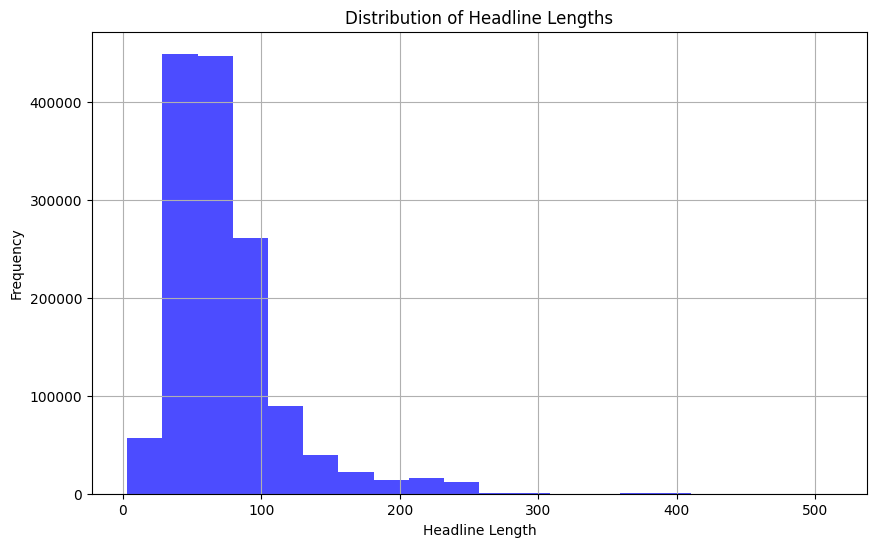

In [16]:
# Obtain headline length statistics
preprocessor.headline_length_statistics()

### Count the number of articles per publisher to identify which publishers are most active.

Number of Articles Per Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Stock Market Newz         1
Paco Ahlgren              1
Miri Segal                1
The Professor             1
Jose Rodrigo              1
Name: count, Length: 1034, dtype: int64


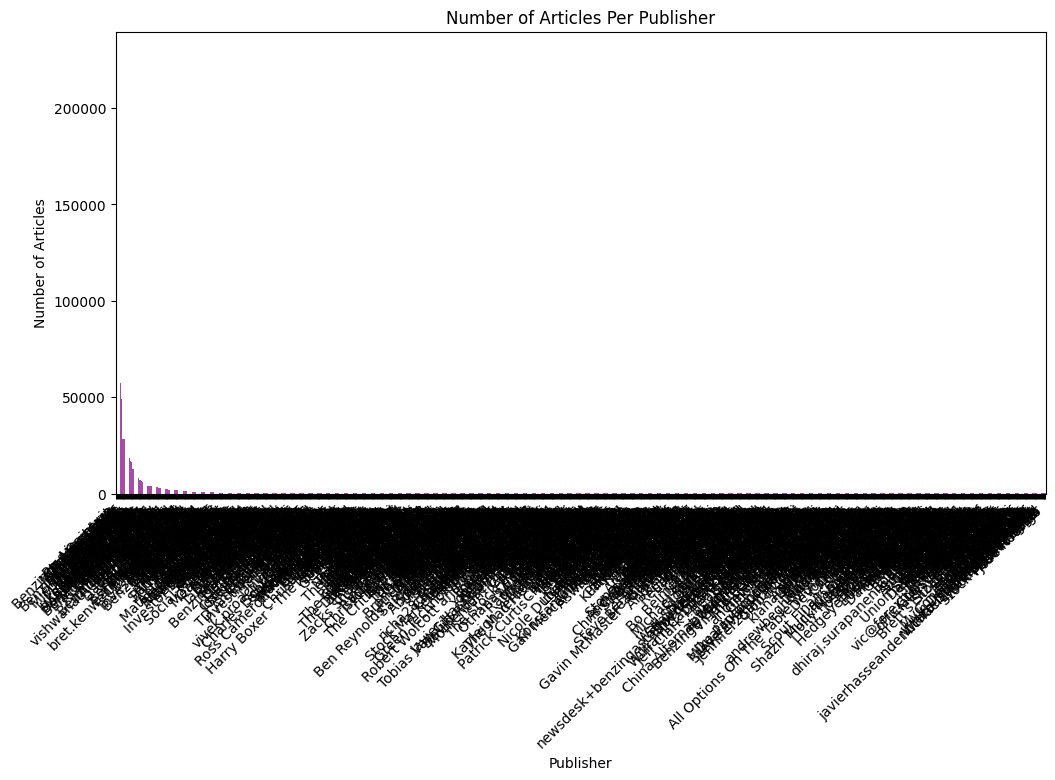

In [17]:
# Count articles per publisher and visualize
preprocessor.count_articles_per_publisher()

### Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

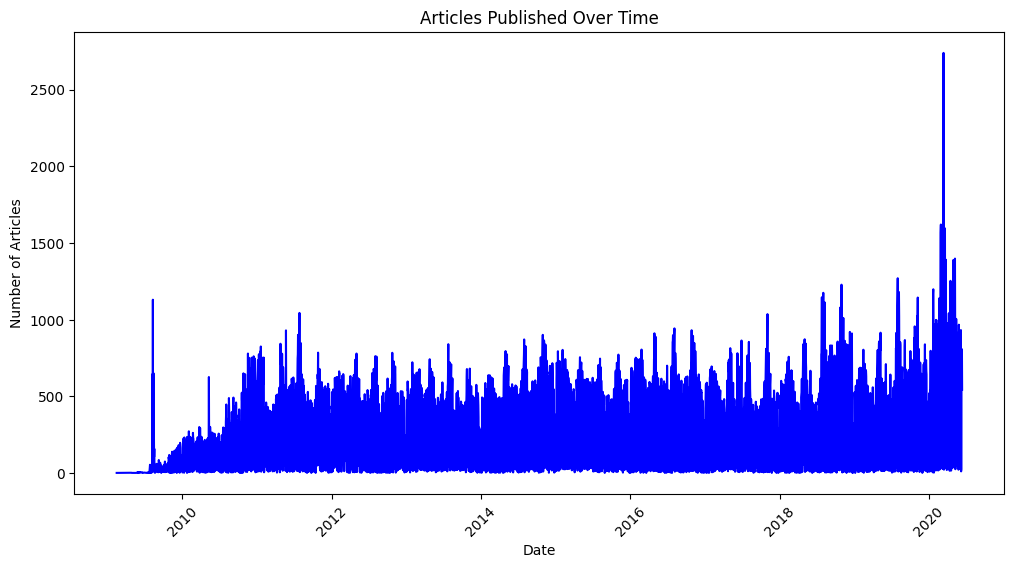

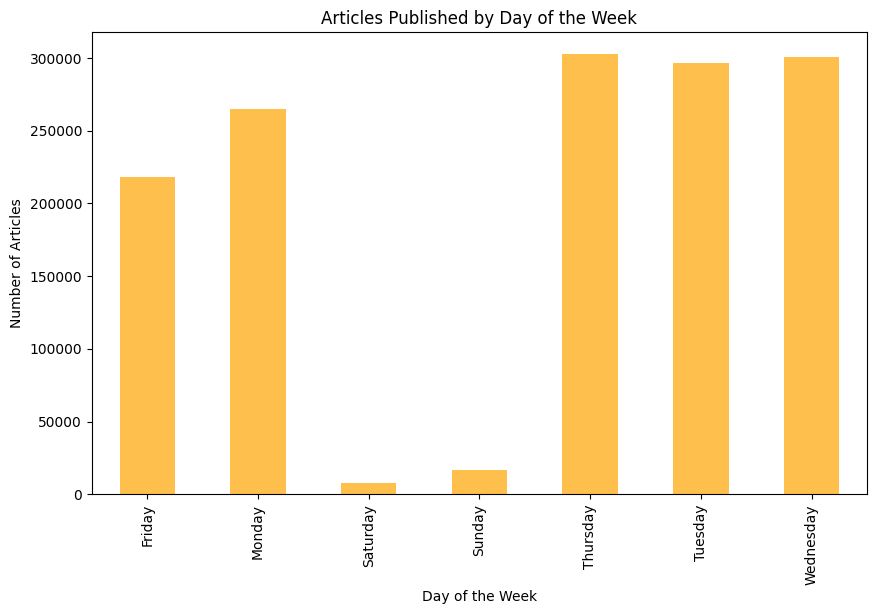

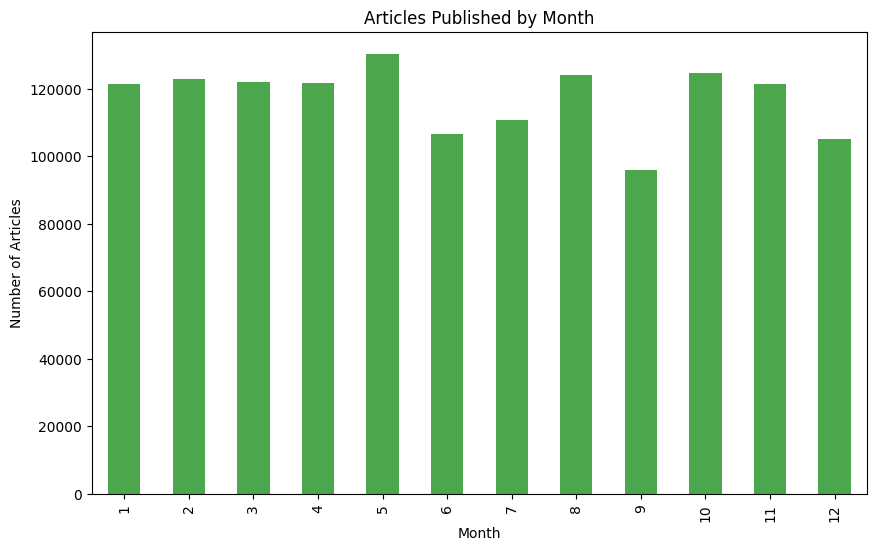

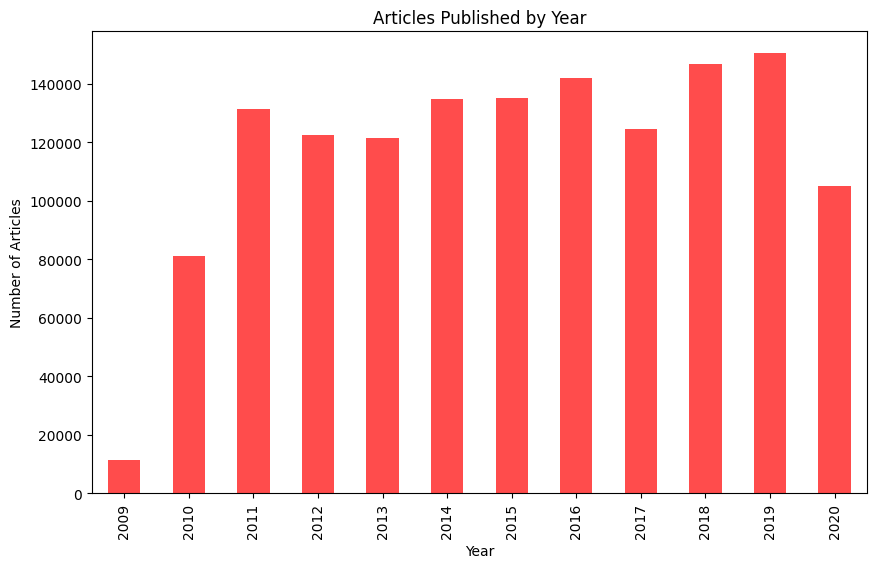

In [18]:
# Analyze publication dates and visualize trends
preprocessor.analyze_publication_dates()

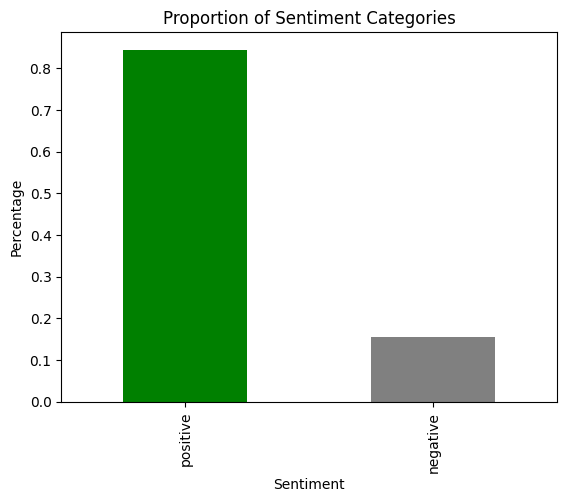

In [19]:
# Determine sentiment categories and visualize
preprocessor.determine_sentiment_category()

# Text Analysis(Sentiment analysis & Topic Modeling):
* Perform sentiment analysis on headlines to gauge the sentiment (positive, negative, neutral) associated with the news.
* Use natural language processing to identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.).

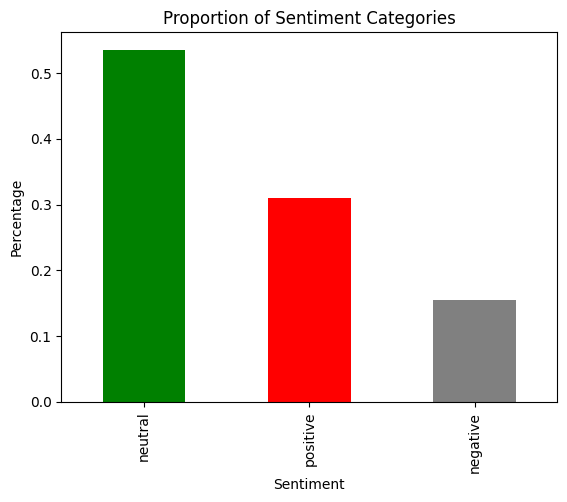

In [20]:
# Initialize the Insight class with your dataframe
insight = Insight(df)

# Perform sentiment analysis and visualize the results
insight.sentiment_analysis()

Topic 1:
earnings scheduled watch etfs stocks benzinga february etf 2016 2015


Topic 2:
hit stocks week shares 52 trading highs says lows higher


Topic 3:
vs est eps pt reports raises buy maintains 00 sales


Topic 4:
stocks week 52 new set industry highest low announces hitting


Topic 5:
market benzinga session moving mid biggest movers day stocks pre




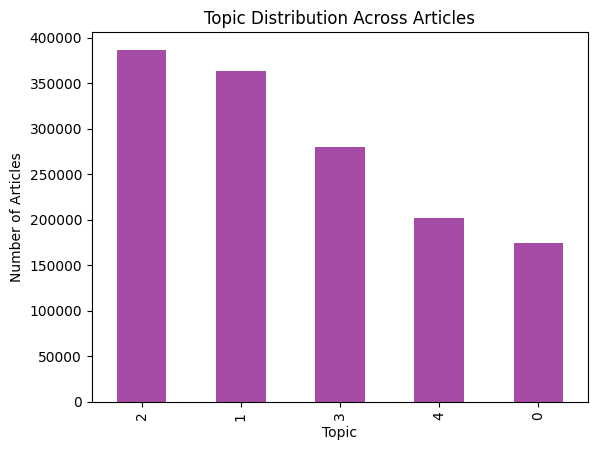

In [21]:
# Perform topic modeling and visualize the extracted topics
insight.topic_modeling(num_topics=5, num_words=10)

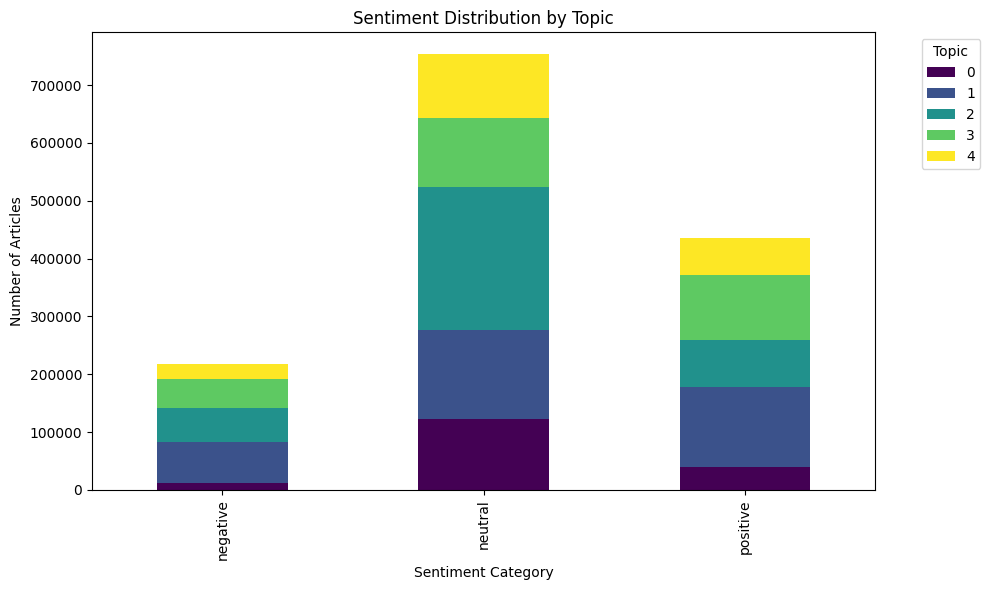

In [22]:
# Plot sentiment vs. topic distribution
insight.plot_sentiment_vs_topic_distribution()

# Time Series Analysis:
* How does the publication frequency vary over time? Are there spikes in article publications related to specific market events?
* Analysis of publishing times might reveal if there’s a specific time when most news is released, which could be crucial for traders and automated trading systems.

In [ ]:
# Create a TimeSeries object
news_analysis = TimeSeries(df)
# Perform correlation analysis
news_analysis.analyze_correlation(merged_df)

In [ ]:
# Initialize the TimeSeries class with your dataframe
time_series = TimeSeries(df)

# Analyze publication frequency over time with daily frequency
time_series.analyze_publication_frequency(time_unit='D')

# Analyze publishing times (hour, day of week, and month)
time_series.analyze_publishing_times()


# Publisher Analysis:
* Which publishers contribute most to the news feed? Is there a difference in the type of news they report?
* If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.

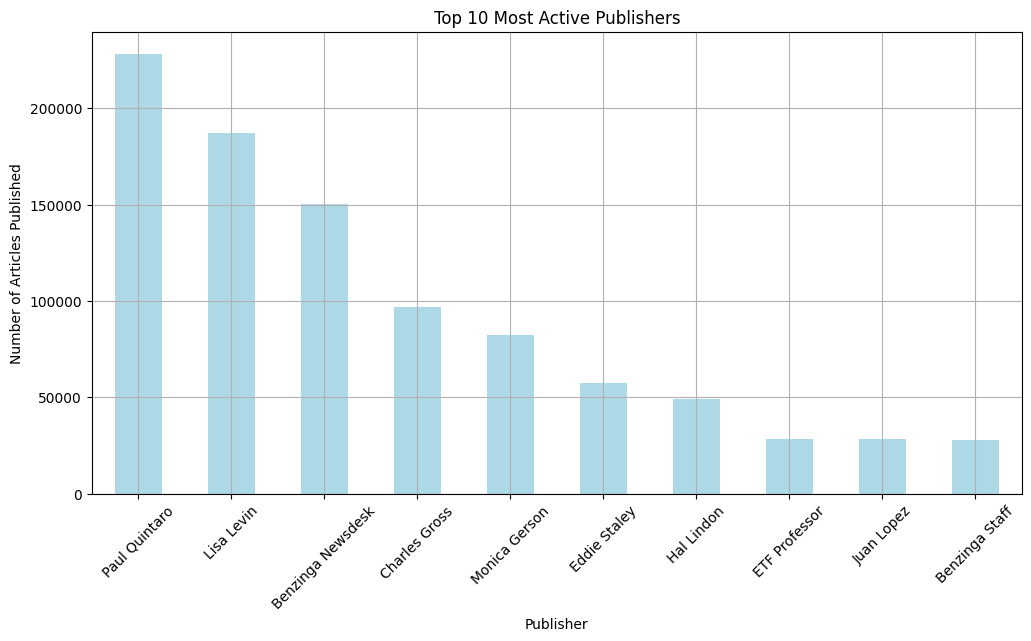

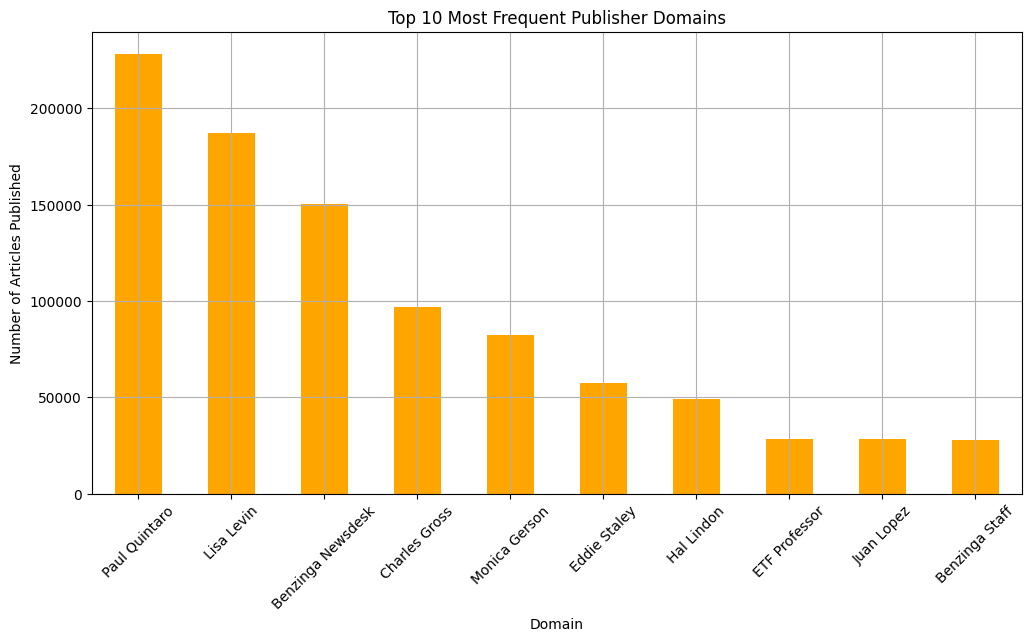

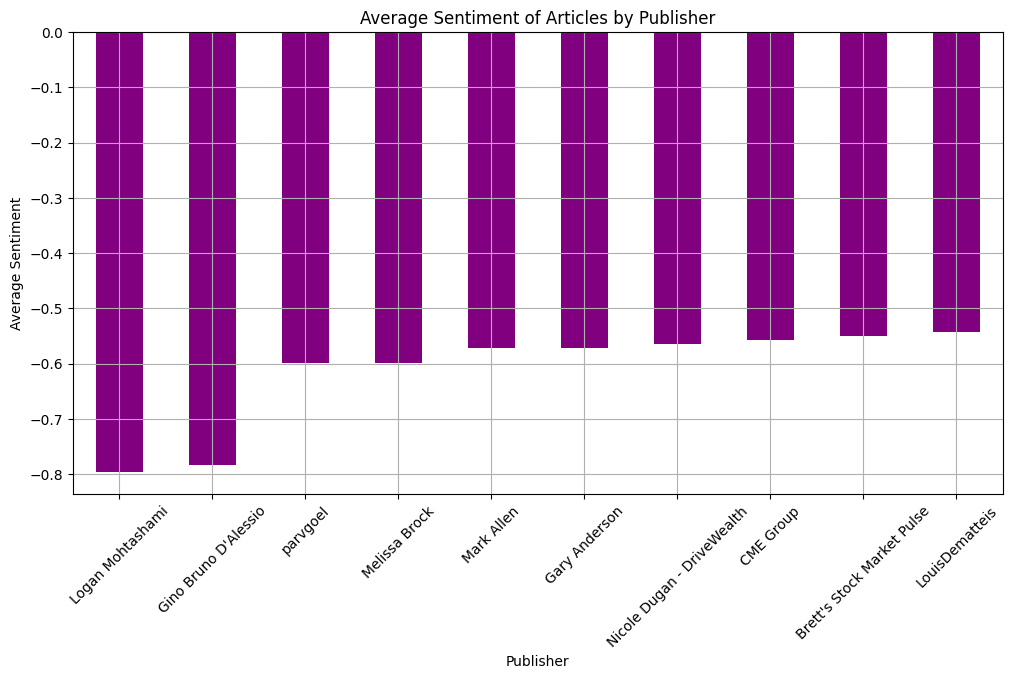

In [24]:
# Analyze publishers contributing to the news feed
time_series.analyze_publishers()

In [ ]:
# # Categorize and visualize sentiment
# eda_stock_news.setement_category()

In [ ]:
# Plot sentiment distribution
eda_stock_news.plot_sentiment_distribution()

c:\Users\Admin\10_Academy_AI_Mastery_kifiya_Week_1\scripts\EDA.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=self.dataframe, x='headline', palette='viridis')


In [ ]:
# Visualize word counts
eda_stock_news.visualize_word_counts()

In [ ]:
# Plot correlation heatmap
eda_stock_news.correlation_heatmap()

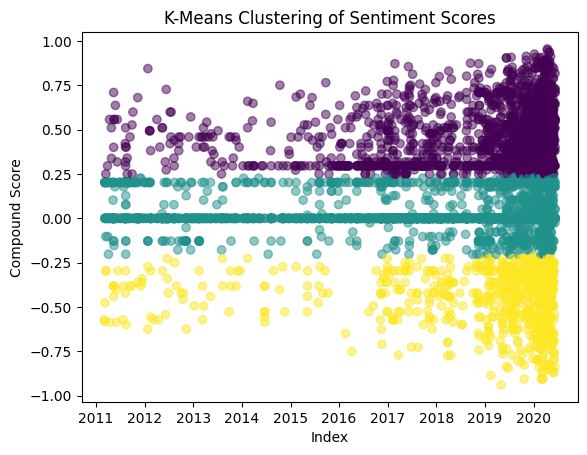

In [106]:
from sklearn.cluster import KMeans

scores = df['sentiment'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(scores)
df['sentiment_cluster'] = kmeans.labels_

# Visualize clusters
plt.scatter(df.index, df['sentiment'], c=df['sentiment_cluster'], cmap='viridis', alpha=0.5)
plt.title("K-Means Clustering of Sentiment Scores")
plt.xlabel("Index")
plt.ylabel("Compound Score")
plt.show()


## Cross validation for thresholding 

In [70]:
thresholds = [-0.2, -0.1, 0.0, 0.1, 0.2]
for threshold in thresholds:
    df['sentiment_category'] = df['sentiment'].apply(
        lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral'
    )
    print(f"Threshold: {threshold}")
    print(df['sentiment_category'].value_counts(normalize=True))


Threshold: -0.2
sentiment_category
positive    0.876731
negative    0.123269
Name: proportion, dtype: float64
Threshold: -0.1
sentiment_category
positive    0.842659
negative    0.157341
Name: proportion, dtype: float64
Threshold: 0.0
sentiment_category
neutral     0.515831
positive    0.320553
negative    0.163616
Name: proportion, dtype: float64
Threshold: 0.1
sentiment_category
neutral     0.531219
positive    0.311441
negative    0.157341
Name: proportion, dtype: float64
Threshold: 0.2
sentiment_category
neutral     0.584278
positive    0.292453
negative    0.123269
Name: proportion, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_9616\1658713762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_category'] = df['sentiment'].apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_9616\1658713762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_category'] = df['sentiment'].apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_9616\1658713762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

<Axes: xlabel='Threshold', ylabel='value'>

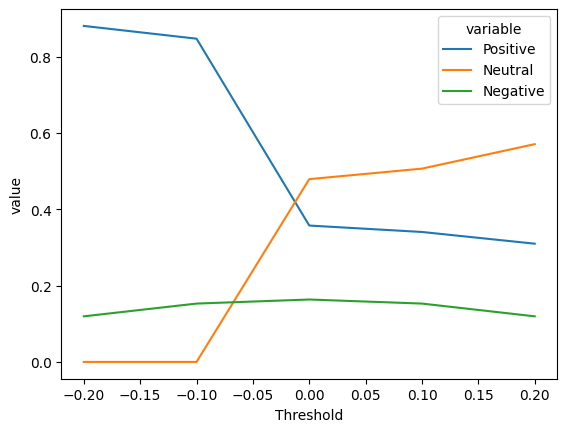

In [79]:
thresholds = [-0.2, -0.1, 0.0, 0.1, 0.2]
proportions = {
    'Threshold': [],
    'Positive': [],
    'Neutral': [],
    'Negative': []
}

for threshold in thresholds:
    df['sentiment_category'] = df['sentiment'].apply(
        lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral'
    )
    sentiment_counts = df['sentiment_category'].value_counts(normalize=True)
    proportions['Threshold'].append(threshold)
    proportions['Positive'].append(sentiment_counts.get('positive', 0))
    proportions['Neutral'].append(sentiment_counts.get('neutral', 0))
    proportions['Negative'].append(sentiment_counts.get('negative', 0))

sns.lineplot(x='Threshold', y='value', hue='variable',
             data=pd.melt(pd.DataFrame(proportions), id_vars=['Threshold']))


## Frequency distribution for thresholding purpose

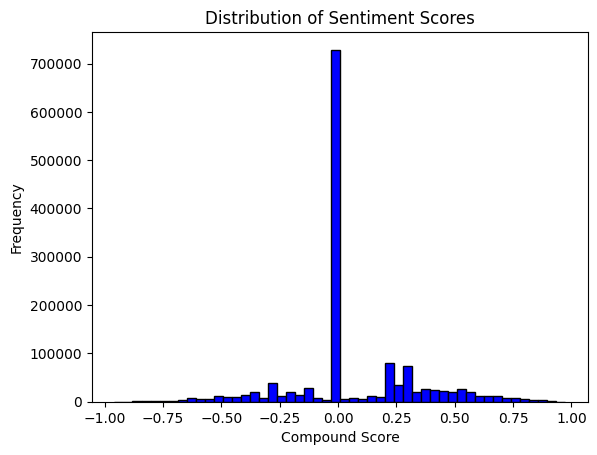

In [22]:
# Plot the distribution of compound scores
plt.hist(df['sentiment'], bins=50, color='blue', edgecolor='black')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.show()


I use the stack sentiment that I have a dataset like META, NVDA, AAPL, AMZN, GOOGL, MSFT, and TSLA

In [71]:
df = df[(df['stock'] == "NVDA") | (df['stock'] == "AAPL") | (df['stock'] == "AMZN") | (df['stock'] == "GOOG")| (df['stock'] == "META") | (df['stock'] == "MSFT")| (df['stock'] == "TSLA")]

In [129]:
# Keep relevant columns for quantitative analysis
quant_df = df[['date', 'stock', 'sentiment']].copy()
quant_df.tail()

,date,stock,sentiment
1039004,2020-06-11 20:49:41+00:00,PVH,0.0000
1357564,2020-06-11 20:51:33+00:00,WMT,0.2732
1269090,2020-06-11 21:01:39+00:00,TWTR,-0.2500
980443,2020-06-11 21:11:20+00:00,PCG,0.4215
1343658,2020-06-11 21:12:35+00:00,WFC,0.0000


In [ ]:
# Simulate dummy stock prices for demonstration
np.random.seed(42)
unique_stocks = quant_df['stock'].unique()
price_data = {stock: np.random.uniform(50, 500, len(quant_df[quant_df['stock'] == stock])) for stock in unique_stocks}

# Add dummy prices to the dataframe
quant_df['price'] = quant_df.apply(lambda row: price_data[row['stock']].pop(0), axis=1)
print(quant_df.head())

In [9]:
from pyti import simple_moving_average as sma
# sma_values = sma.simple_moving_average(close_prices, period=20)